In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import models
import time
import glob
import PIL
import os
from PIL import Image

In [2]:
DATA_PATH='RSI-CB256/data'

# Defining image transformations
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((100,100)),
    # Normalize the image
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [3]:
# Defining hyperparameters
batch_size = 32
num_epochs = 20
learning_rate = 0.0003

In [4]:
data = datasets.ImageFolder(DATA_PATH, transform = transform) # Fetching dataset from folder

# train-test split
train_size = int(0.7 * len(data)) 
test_size = int(0.2 * len(data))
val_size = int(len(data) - (train_size+test_size))
train_dataset, test_dataset, val_dataset = random_split(data, [train_size, test_size, val_size])


print(f"Dataset has {len(data)} data points.")
print(f"Train Dataset has {len(train_dataset)} data points")
print(f"Test Dataset has {len(test_dataset)} data points.") 
print(f"Validation Dataset has {len(val_dataset)} data points.") 

Dataset has 5631 data points.
Train Dataset has 3941 data points
Test Dataset has 1126 data points.
Validation Dataset has 564 data points.


In [5]:
train_loader = DataLoader(train_dataset, batch_size= batch_size, num_workers=2, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size= batch_size, num_workers=2, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= batch_size, num_workers=2, shuffle= True)

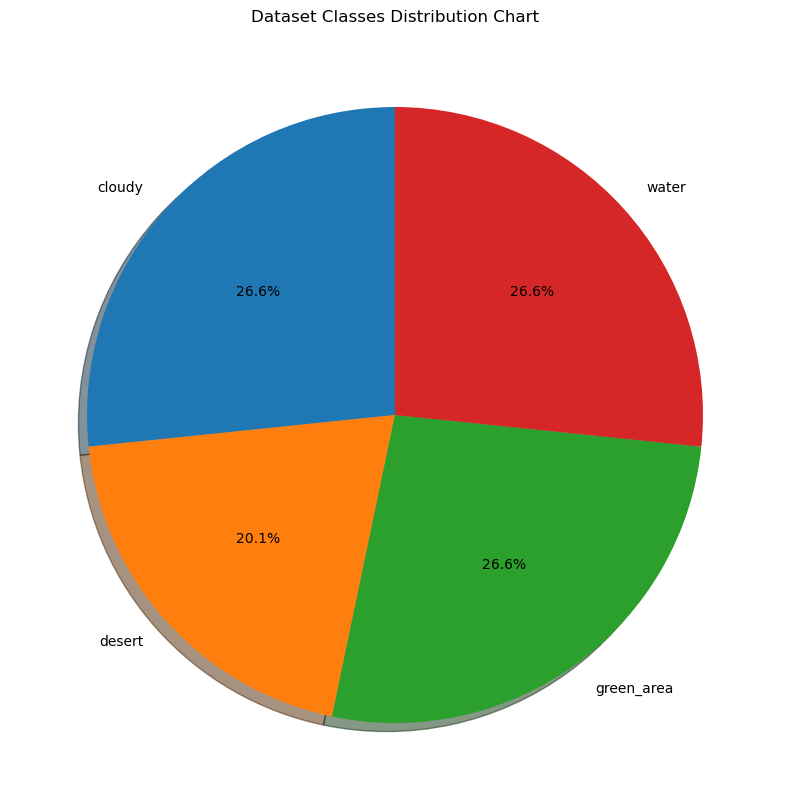

{'cloudy': 1499, 'desert': 1130, 'green_area': 1499, 'water': 1499}


In [6]:
# Visualizing data distrubitons accordin to classes
class_names_train = os.listdir(DATA_PATH)

image_count = {}
for i in class_names_train:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i))) - 1

    
# Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        textprops=dict(color="black"),
        autopct = '%1.1f%%',
        startangle=90)
plt.title("Dataset Classes Distribution Chart", color='black')
plt.show()
print(image_count)

In [7]:
# Defining Model
model = models.densenet121()

for param in model.parameters():
    param.require_grad = False
    
fc = nn.Sequential(
    nn.Linear(1024,460),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(460, 5)
)

model.classifier = fc
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Device: cuda:0


In [8]:
total_steps = len(train_loader)
t1 = time.time()
train_accuracy = []
val_accuracy = []
training_loss = []
epoch_accuracy = 0
total_label_i = 0
validation_loss=[]


for epoch in range(num_epochs):
    epoch_loss = 0
    correct_v=0 
    correct=0 
    total_v=0 
    total=0
    train_loss =0.0 
    
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total += labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item() 
        
        total_label_i += total
        epoch_accuracy += (predicted == labels).float().sum()
        
    valid_loss=0.0;
    for i_v, data_v in enumerate(val_loader):
        images_v, labels_v = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs_v = model(images_v)
        loss_v = criterion(outputs_v, labels_v)
        total_v += labels_v.size(0)
        _,predicted_v = torch.max(outputs_v.data, 1)
        correct_v += (predicted_v == labels_v).sum().item()
        valid_loss += loss_v.item()
    
    train_accuracy.append(round((correct/total)*100, 2))
    val_accuracy.append(round((correct_v/total_v)*100, 2))
    training_loss.append(train_loss/len(train_loader))
    validation_loss.append(valid_loss/len(val_loader))

    print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'
        .format(epoch + 1, num_epochs, (train_loss/len(train_loader)), (valid_loss/len(val_loader)), (correct / total) * 100, 
          (correct_v / total_v) * 100))
            
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Epoch [1/20], Training Loss: 0.4243, Validation Loss: 1.8714, Training Accuracy: 85.64%, Validation Accuracy: 60.00%
Epoch [2/20], Training Loss: 0.2823, Validation Loss: 0.9141, Training Accuracy: 88.94%, Validation Accuracy: 80.00%
Epoch [3/20], Training Loss: 0.2211, Validation Loss: 0.0111, Training Accuracy: 92.39%, Validation Accuracy: 100.00%
Epoch [4/20], Training Loss: 0.1941, Validation Loss: 0.5522, Training Accuracy: 94.04%, Validation Accuracy: 80.00%
Epoch [5/20], Training Loss: 0.1683, Validation Loss: 0.4802, Training Accuracy: 94.47%, Validation Accuracy: 62.22%
Epoch [6/20], Training Loss: 0.1969, Validation Loss: 0.1160, Training Accuracy: 93.61%, Validation Accuracy: 96.67%
Epoch [7/20], Training Loss: 0.1690, Validation Loss: 0.7118, Training Accuracy: 94.95%, Validation Accuracy: 80.00%
Epoch [8/20], Training Loss: 0.1372, Validation Loss: 0.0178, Training Accuracy: 95.46%, Validation Accuracy: 100.00%
Epoch [9/20], Training Loss: 0.1380, Validation Loss: 0.1366, 

In [9]:
torch.save(model.state_dict(), "rsicb-densenet.pt")

In [10]:
#TSNE
model.eval()
targets_list = []
outputs_list = []

with torch.no_grad():
    for idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets_np = targets.data.cpu().numpy()

        outputs = model(inputs)
        outputs_np = outputs.data.cpu().numpy()

        targets_list.append(targets_np[:, np.newaxis])
        outputs_list.append(outputs_np)

targets = np.concatenate(targets_list, axis=0)
outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

generating t-SNE plot...


C:\Users\solan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\solan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\solan\AppData\Local\Temp\ipykernel_59576\375346950.py:14: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


done!


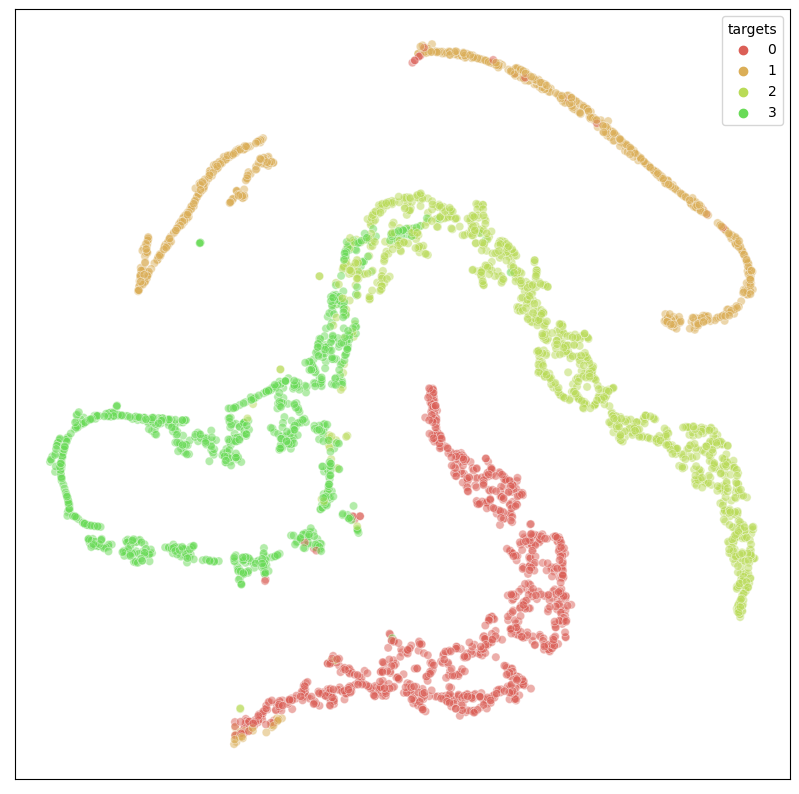

In [11]:
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
print('generating t-SNE plot...')
# tsne_output = bh_sne(outputs)
tsne = TSNE(random_state=0)
tsne_output = tsne.fit_transform(outputs)

df = pd.DataFrame(tsne_output, columns=['x', 'y'])
df['targets'] = targets

plt.rcParams['figure.figsize'] = 10, 10
sns.scatterplot(
    x='x', y='y',
    hue='targets',
    palette=sns.color_palette("hls", 10),
    data=df,
    marker='o',
    legend="full",
    alpha=0.5
)

plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

# plt.savefig(os.path.join(save_dir,'tsne.png'), bbox_inches='tight')
print('done!')

In [12]:
# Calculating Test Accuracy
model.eval() 

with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

Test Accuracy of the model on the 1126 test images: 94.49378330373001 %


In [13]:
print(training_loss)
print(validation_loss)

[0.4243015716032636, 0.28230400140126866, 0.22114751476704353, 0.19407227229807647, 0.16830450656162876, 0.19693085085600615, 0.16902238079496928, 0.13717091631805223, 0.1380126524506317, 0.16174962390364417, 0.14790429799036392, 0.1228260261216952, 0.14790844824165106, 0.15724807520276837, 0.1334180614926041, 0.12682032320768602, 0.12440528535854913, 0.11886133645631132, 0.0977359835298792, 0.0867147939636432]
[1.8713611960411072, 0.9140890604919858, 0.011062399846398167, 0.5522123393085268, 0.48017747865782845, 0.11603768707977401, 0.7117536200417413, 0.017846810372753277, 0.13658845383259985, 2.342864844534132, 1.9154612090852525, 0.09473150430454148, 0.3306269281440311, 0.048381918420394264, 1.7633108297983806, 0.2908616347445382, 0.05257887227667703, 0.5890762474801805, 0.020449436942322388, 0.37448831150929135]


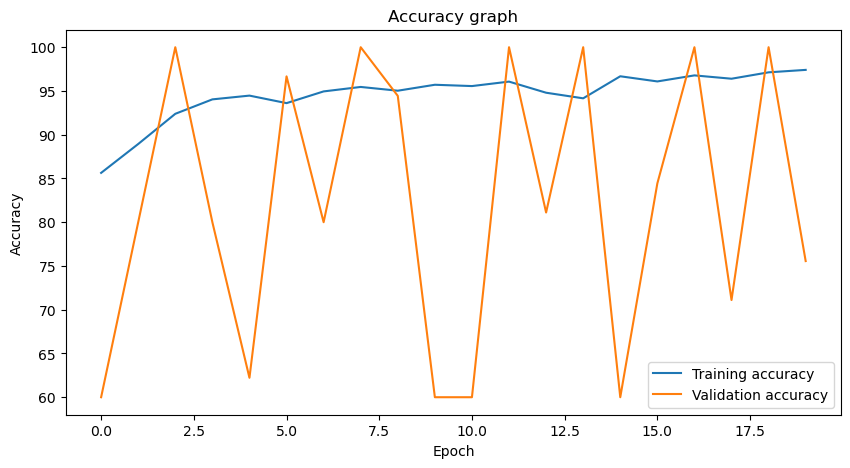

In [14]:
epochs = [i for i in range(num_epochs)]
plt.figure(figsize=(10,5))
plt.title("Accuracy graph")
plt.plot(epochs, train_accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

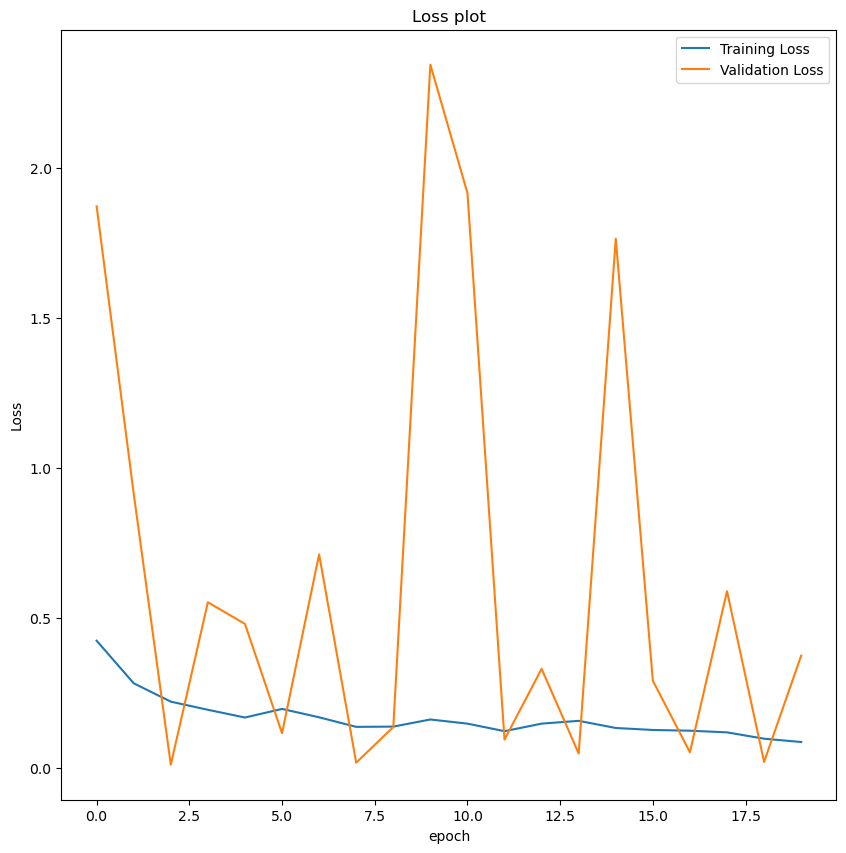

In [15]:
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')

plt.legend()

[[108   0   0]
 [  0  72   0]
 [  0   0  36]]


<AxesSubplot:>

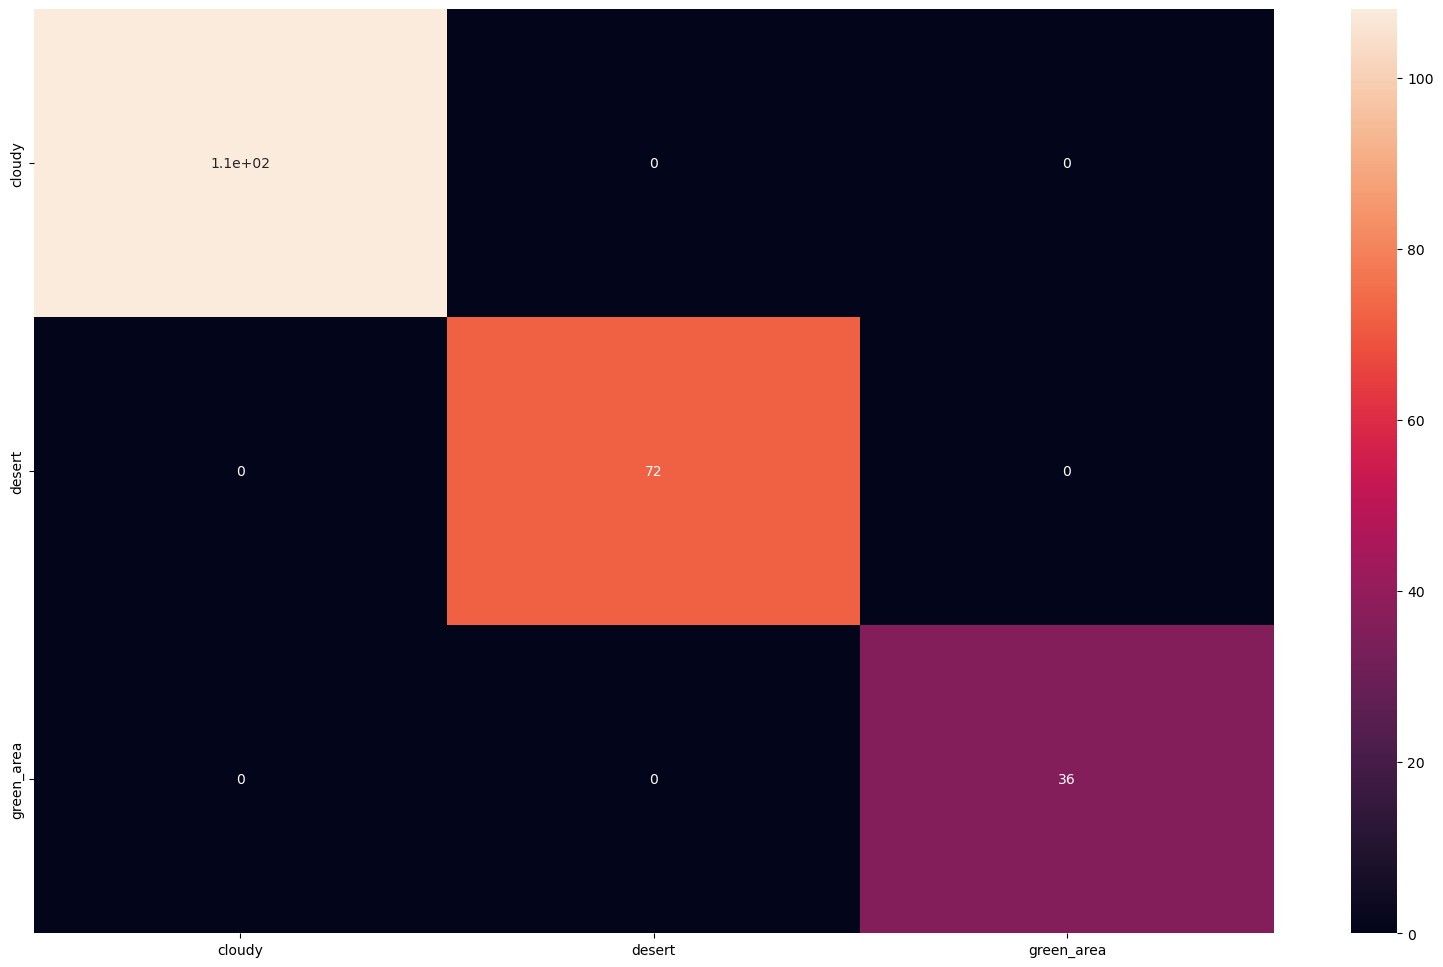

In [17]:
y_pred = []
y_true = []

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

for inputs, labels in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('cloudy', 'desert', 'green_area')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

import seaborn as sns

# sns.heatmap(cf_matrix, annot=True)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20, 12))
sn.heatmap(df_cm, annot=True)
# plt.savefig('Confusion_matrix_AlexNet_Fer_PreTrained.png')

In [19]:
model = torch.load("rsicb-densenet.pt")
# model.load_state_dict(torch.load("rsicb-densenet.pt"))
model.eval()

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [ ]:
# Calculating Test Accuracy
device = torch.device("cpu")

with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

In [ ]:
#T-SNE For RSI-CB

import random
import numpy as np
import pickle
from PIL import Image
from scipy.spatial import distance
import igraph
import cv2
import os
from skimage import io
from sklearn.feature_extraction import image 
from sklearn.manifold import TSNE
from tqdm import tqdm
%matplotlib inline

In [ ]:
data = []
folder = 'RSI-CB256/data/'
fold=['cloudy/','desert/','green_area/','water/']
for f in fold:
    for filename in tqdm((os.listdir(folder+f))):
        image = cv2.imread(os.path.join(folder+f,filename))
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (45,45))
            image = image.flatten()
            data.append([image, folder+f+ filename])

In [ ]:
from sklearn.decomposition import PCA
features, images  = zip(*data)

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

num_images_to_plot = len(images)

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [ ]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=350, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

In [ ]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

In [ ]:
import matplotlib.pyplot
from matplotlib.pyplot import imshow

width = 10000
height = 10000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

In [ ]:
# total_step = len(train_loader)
# import time
# print_every = len(train_loader) - 1
# loss_values = []
# start_time = time.time()
# total_step = len(train_loader)
# epoch_times = []

# # Training 
# for epoch in range(num_epochs):
#     for i, (images, labels) in enumerate(train_loader): 
#         epoch_start_time = time.time()
#         running_loss = 0.0
#         images = images.to(device)
#         labels = labels.to(device)
        
#         outputs = model(images)
#         loss = criterion(outputs, labels)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() 
#         if (i+1) % print_every == 0:
#             epoch_times.append(time.time() - epoch_start_time)
#             loss_values.append(running_loss / print_every)
#             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}: Batch Loss : {}' 
#                    .format(epoch+1, num_epochs, i+1, total_step, loss.item(), running_loss / print_every))
#             running_loss = 0
# end_of_training = time.time() - start_time



# arr_pred = np.empty((0,len(test_dataset)), int)

# arr_label = np.empty((0,len(test_dataset)), int)

# # Prediction
# with torch.no_grad(): 
#     correct = 0
#     total = 0
#     for images, labels in test_loader: 
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
        
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         pred = predicted.cpu().numpy()
#         lb = labels.cpu().numpy()
#         arr_pred = np.append(arr_pred, pred)
#         arr_label = np.append(arr_label, lb)
        
#     print('Test Accuracy of the model on the ' + str(len(test_dataset)) + ' test images: {} %'.format(100 * correct / total))